# Day Energy Model
Training a model on manually labelled EEG data to find various states.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data-day"
stats_df = pd.read_csv(input_dir + os.path.sep + "day_stats.csv")


In [3]:
from models.eeg_states.eeg_states import load_and_prepare_day_data_energy_eeg_state_events

events = load_and_prepare_day_data_energy_eeg_state_events()

C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-11-15 09:34:49.320000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:117: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [4]:
events

,version,event,phase,duration,TimestampUK,SinceUK,dayAndNightOf
0,v1,tired_long,day,0 days 00:05:00,2024-11-15 09:39:49.320000+00:00,2024-11-15 09:34:49.320000+00:00,2024-11-15
1,v1,tired_long,day,0 days 00:02:50.530000,2024-11-15 09:42:39.850000+00:00,2024-11-15 09:39:49.320000+00:00,2024-11-15
2,v1,tired_long,day,0 days 00:01:14.072000,2024-11-15 09:43:53.922000+00:00,2024-11-15 09:42:39.850000+00:00,2024-11-15
3,v1,tired_long,day,0 days 00:03:34.874000,2024-11-15 09:47:28.796000+00:00,2024-11-15 09:43:53.922000+00:00,2024-11-15
4,v1,tired_long,day,0 days 00:03:59.597000,2024-11-15 09:51:28.393000+00:00,2024-11-15 09:47:28.796000+00:00,2024-11-15
5,v1,tired_long,day,0 days 00:00:17.205000,2024-11-15 09:51:45.598000+00:00,2024-11-15 09:51:28.393000+00:00,2024-11-15
6,v1,tired_long,day,0 days 00:00:44.459000,2024-11-15 09:52:30.057000+00:00,2024-11-15 09:51:45.598000+00:00,2024-11-15
7,v1,tired_long,day,0 days 00:01:16.604000,2024-11-15 09:53:46.661000+00:00,2024-11-15 09:52:30.057000+00:00,2024-11-15
8,v1,tired_long,day,0 days 00:01:54.750000,2024-11-15 09:55:41.411000+00:00,2024-11-15 09:53:46.661000+00:00,2024-11-15
9,v1,tired_long,day,0 days 00:01:25.802000,2024-11-15 09:57:07.213000+00:00,2024-11-15 09:55:41.411000+00:00,2024-11-15


## Load other data

In [5]:
import os

dfs = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.output.csv")
        if os.path.exists(input_file):
            df = pd.read_csv(input_file)
            df['TimestampUK'] = pd.to_datetime(df['TimestampUK'])
            dfs.append(df)

yasa_df = pd.concat(dfs, ignore_index=True)

In [6]:
yasa_df.shape

(311, 435)

In [7]:
yasa_df.head()

,epoch,TimestampUK,Fpz-M1_eeg_abspow,Fpz-M1_eeg_abspow_c7min_norm,Fpz-M1_eeg_abspow_p2min_norm,Fpz-M1_eeg_alpha,Fpz-M1_eeg_alpha_c7min_norm,Fpz-M1_eeg_alpha_p2min_norm,Fpz-M1_eeg_alphaaa,Fpz-M1_eeg_alphaaa_c7min_norm,...,Main_eeg_thetaab_p2min_norm_s,Main_eeg_thetaabs_s,Main_eeg_thetaabs_c7min_norm_s,Main_eeg_thetaabs_p2min_norm_s,Main_eeg_thetaabsaa_s,Main_eeg_thetaabsaa_c7min_norm_s,Main_eeg_thetaabsaa_p2min_norm_s,Main_eeg_thetaabsab_s,Main_eeg_thetaabsab_c7min_norm_s,Main_eeg_thetaabsab_p2min_norm_s
0,0,2024-11-15 09:10:50.479561090+00:00,7.072715e-09,0.155163,1.186594,0.012408,-0.441512,-0.259280,0.017858,-0.389062,...,0.933191,8.659223,0.186914,1.813158,6.655437,0.224610,1.869854,5.111267,0.420865,2.177979
1,1,2024-11-15 09:11:20.479561090+00:00,2.076430e-09,0.059034,0.463656,0.017996,-0.463431,0.416601,0.026784,-0.373252,...,0.351043,3.110920,0.071126,0.871326,2.436167,0.098082,0.919893,1.427058,0.237766,0.905256
2,2,2024-11-15 09:11:50.479561090+00:00,4.383291e-09,0.057731,0.445204,0.006967,-0.537483,-0.247380,0.010442,-0.426132,...,0.302478,4.238875,0.091098,0.685031,3.100316,0.111331,0.702927,3.115556,0.224837,0.869880
3,3,2024-11-15 09:12:20.479561090+00:00,1.534609e-09,0.027714,0.229883,0.014031,-0.403262,-0.152210,0.022444,-0.343588,...,0.393451,1.159161,0.099428,0.330490,0.967333,0.120250,0.354325,1.029705,0.162226,0.491910
4,4,2024-11-15 09:12:50.479561090+00:00,3.456014e-09,0.033122,-0.031776,0.011661,-0.262787,-0.197386,0.016679,-0.278007,...,0.157906,3.059041,0.176791,-0.144829,2.410881,0.196580,-0.123502,2.371310,0.164572,0.018646


# Prepare data - find if in state

In [8]:
from models.eeg_states.eeg_states import process_row

row = yasa_df.iloc[44]
print(row['TimestampUK'])
process_row(yasa_df.iloc[44], events, True)

2024-11-15 09:35:03.913367987+00:00
Epoch start 2024-11-15 09:35:03.913367987+00:00 end 2024-11-15 09:35:33.913367987+00:00 event tired_long start 2024-11-15 09:34:49.320000+00:00 end 2024-11-15 09:39:49.320000+00:00 > False < True


('tired', 0)

In [9]:
from models.eeg_states.eeg_states import process_row
import pandas as pd
from tqdm import tqdm

# Add new columns to yasa_df to store the epoch type
yasa_df['energy_manual_score'] = None
yasa_df['matched_event'] = None

# Iterate over each row in yasa_df
for i, yasa_row in tqdm(yasa_df.iterrows(), total=yasa_df.shape[0]):
    epoch_type, matched_night_event = process_row(yasa_row, events)
    yasa_df.at[i, 'energy_manual_score'] = epoch_type
    yasa_df.at[i, 'matched_event'] = matched_night_event

100%|██████████| 311/311 [00:00<00:00, 1131.93it/s]


In [10]:
yasa_df['energy_manual_score'].value_counts()

energy_manual_score
tired         170
struggling     10
near worst      1
Name: count, dtype: int64

In [11]:
yasa_df[['TimestampUK', 'energy_manual_score']]

,TimestampUK,energy_manual_score
0,2024-11-15 09:10:50.479561090+00:00,None
1,2024-11-15 09:11:20.479561090+00:00,None
2,2024-11-15 09:11:50.479561090+00:00,None
3,2024-11-15 09:12:20.479561090+00:00,None
4,2024-11-15 09:12:50.479561090+00:00,None
...,...,...
306,2024-11-15 11:46:03.913367987+00:00,None
307,2024-11-15 11:46:33.913367987+00:00,None
308,2024-11-15 11:47:03.913367987+00:00,near worst
309,2024-11-15 11:47:33.913367987+00:00,struggling


In [12]:
from memory import garbage_collect

garbage_collect(log)

In [13]:
from models.eeg_states.eeg_states_model import day_energy_model_pipeline

models_and_data = [
    day_energy_model_pipeline('day-energy-non-realtime', yasa_df, "energy_manual_score", False),
    day_energy_model_pipeline('day-energy-realtime', yasa_df, "energy_manual_score", True),
]

['Main_eeg_abspow_s', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_db_c7min_norm_s', 'Main_eeg_

In [14]:
from models.eeg_states.eeg_states_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    # Remove when have more data
    md.X_train = md.X
    md.y_train = md.y
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size day-energy-non-realtime: 181, validation set size: 37
Training set size day-energy-realtime: 181, validation set size: 37


In [15]:
models_and_data[0].y_train

43     0.3
44     0.3
45     0.3
46     0.3
47     0.3
      ... 
304    0.1
305    0.1
308    0.0
309    0.1
310    0.1
Name: energy_manual_score, Length: 181, dtype: float64

# Train Catboost model

In [16]:
from catboost import CatBoostRegressor

def train(md: ModelAndData):
    md.model = CatBoostRegressor(
        iterations=2000,                # Number of boosting iterations
        learning_rate=0.03,             # Learning rate
        depth=6,                        # Depth of the tree
        l2_leaf_reg=3,                  # L2 regularization term on weights
        early_stopping_rounds=50        # Early stopping rounds
    )
    log(f"Training model for {md.name}")
    md.model.fit(md.X_train, md.y_train, verbose=100)

for md in models_and_data:
    train(md)

0:	learn: 0.0496091	total: 144ms	remaining: 4m 48s
100:	learn: 0.0102295	total: 598ms	remaining: 11.3s
200:	learn: 0.0043146	total: 956ms	remaining: 8.56s
300:	learn: 0.0020455	total: 1.32s	remaining: 7.43s
400:	learn: 0.0009956	total: 1.7s	remaining: 6.76s
500:	learn: 0.0005410	total: 2.06s	remaining: 6.17s
600:	learn: 0.0003519	total: 2.49s	remaining: 5.8s
700:	learn: 0.0002418	total: 2.95s	remaining: 5.47s
800:	learn: 0.0001575	total: 3.33s	remaining: 4.98s
900:	learn: 0.0000910	total: 3.72s	remaining: 4.53s
1000:	learn: 0.0000551	total: 4.09s	remaining: 4.09s
1100:	learn: 0.0000338	total: 4.46s	remaining: 3.64s
1200:	learn: 0.0000217	total: 4.85s	remaining: 3.23s
1300:	learn: 0.0000137	total: 5.24s	remaining: 2.82s
1400:	learn: 0.0000089	total: 5.63s	remaining: 2.4s
1500:	learn: 0.0000057	total: 6.03s	remaining: 2s
1600:	learn: 0.0000036	total: 6.42s	remaining: 1.6s
1700:	learn: 0.0000023	total: 6.82s	remaining: 1.2s
1800:	learn: 0.0000015	total: 7.2s	remaining: 795ms
1900:	learn: 

## Evaluate the model

Evaluation for model:  day-energy-non-realtime
day-energy-non-realtime Training Set Evaluation:
MAE: 5.208263842248794e-07, MSE: 3.9735828134973373e-13, RMSE: 6.303636104263426e-07


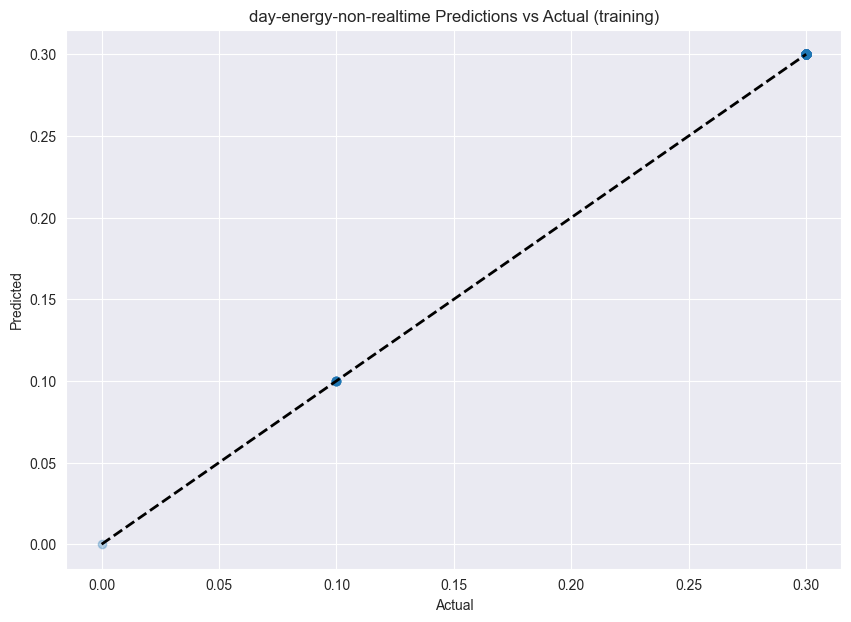

day-energy-non-realtime Validation Set Evaluation:
MAE: 4.0568772825784434e-07, MSE: 2.4110115566088763e-13, RMSE: 4.910205246839359e-07


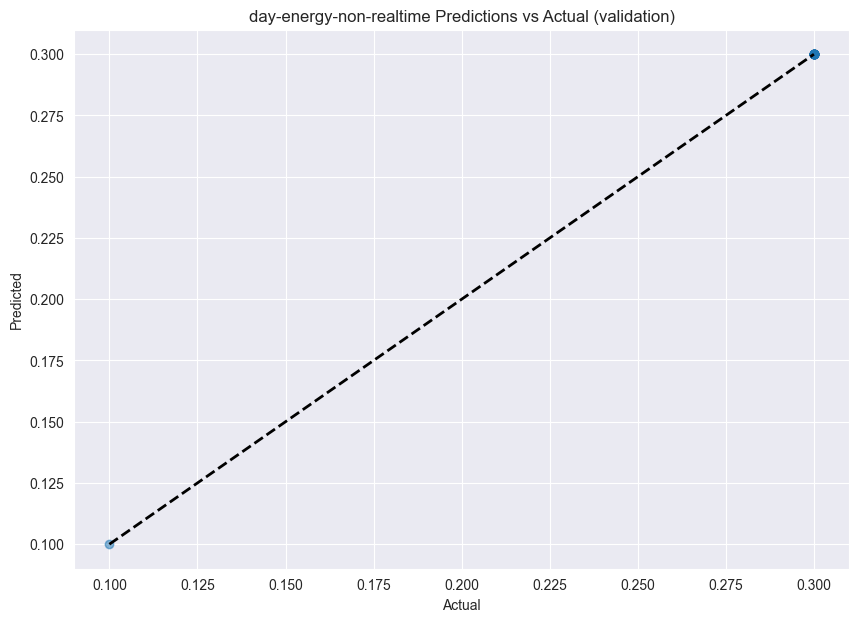

Evaluation for model:  day-energy-realtime
day-energy-realtime Training Set Evaluation:
MAE: 5.252447327678218e-06, MSE: 3.9108634395746955e-11, RMSE: 6.253689662570965e-06


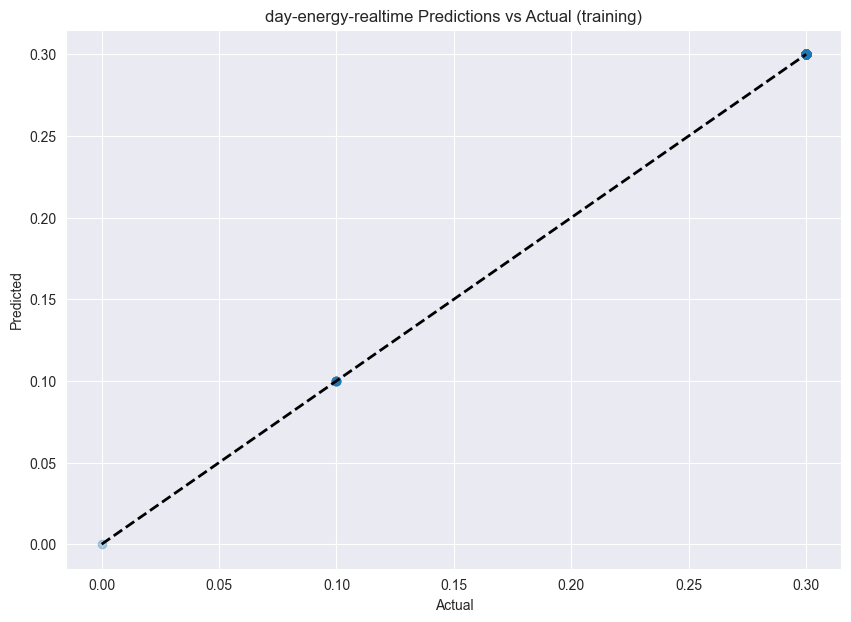

day-energy-realtime Validation Set Evaluation:
MAE: 5.649364587252494e-06, MSE: 4.3882015465618165e-11, RMSE: 6.624350191952277e-06


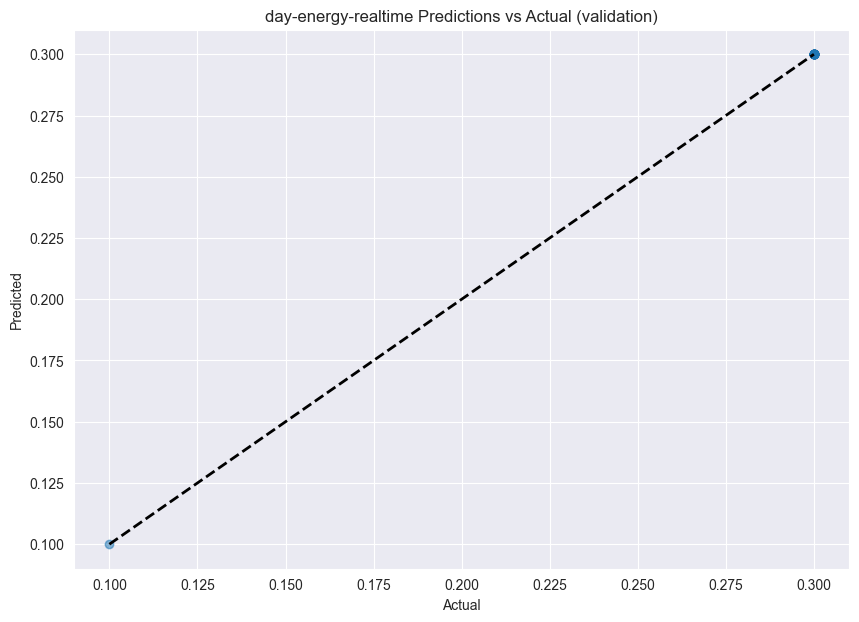

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def evaluate_classification_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    val_train = model.predict(X_train)

    train_results_df = pd.DataFrame({
        'Actual': y_train,
        'Predicted': val_train
    })

    cm_train = confusion_matrix(train_results_df['Actual'], train_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (training)')
    plt.show()

    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    print(val_predictions)
    
    # Create a DataFrame with y_val and the predictions
    val_results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })

    cm_val = confusion_matrix(val_results_df['Actual'], val_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (validation)')
    plt.show()

def evaluate_regression_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)

    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_predictions = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    print(f"MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_train, train_predictions, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (training)')
    plt.show()

    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_predictions = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    print(f"MAE: {val_mae}, MSE: {val_mse}, RMSE: {val_rmse}")

    # Plot the predictions vs actual values for the validation set
    plt.figure(figsize=(10, 7))
    plt.scatter(y_val, val_predictions, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (validation)')
    plt.show()
    
for md in models_and_data:
    evaluate_regression_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

## Most useful features

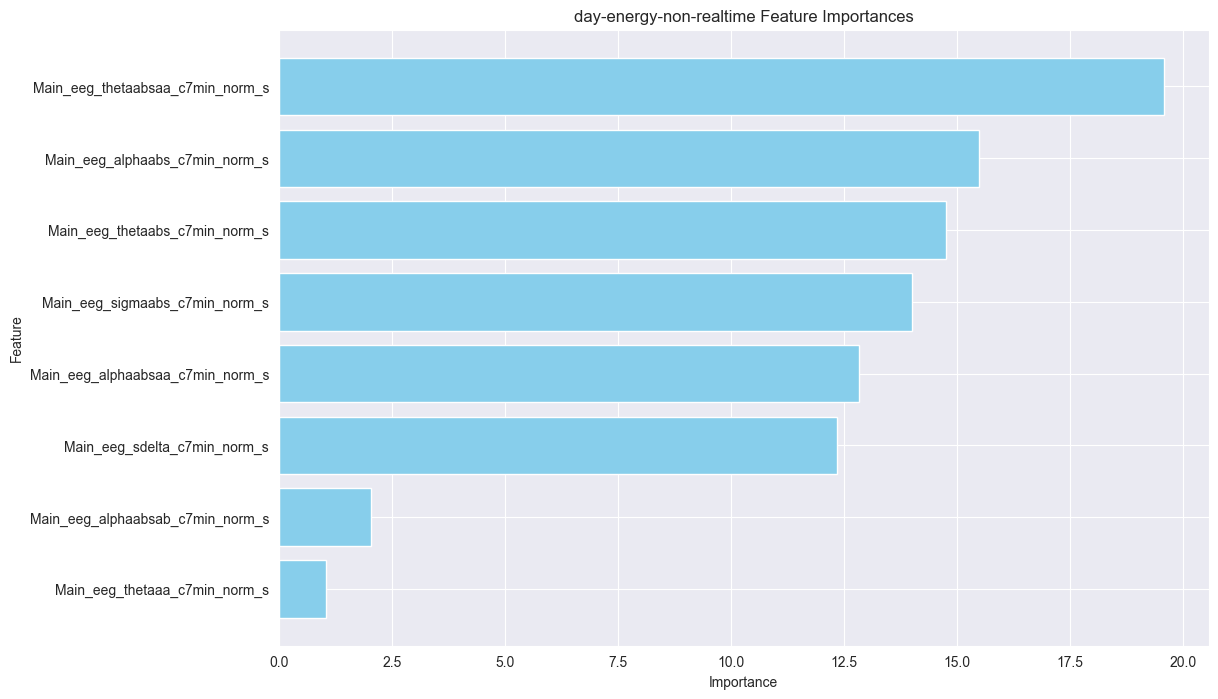

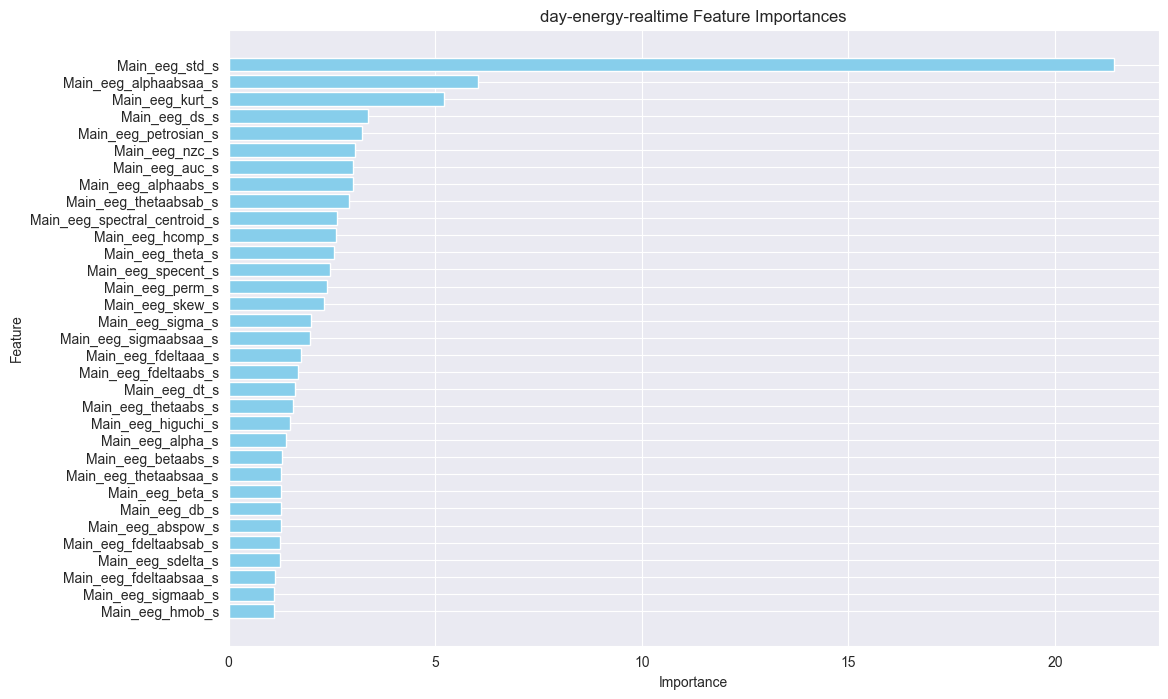

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

for md in models_and_data:
    importances(md)

# Save model

In [19]:
import dotenv
dotenv.load_dotenv()

import paramiko

# Configure logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

def secure_copy_file(local_path, remote_path, hostname, username, password):
    # Create an SSH client
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    ssh.connect(hostname, username=username, password=password)

    # Open an SFTP session
    sftp = ssh.open_sftp()

    # Get the size of the file to be transferred
    file_size = os.path.getsize(local_path)

    # Define a callback function to show progress
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=local_path) as pbar:
        def progress_callback(transferred, total):
            pbar.update(transferred - pbar.n)

        # Copy the file with progress callback
        sftp.put(local_path, remote_path, callback=progress_callback)

    # Close the SFTP session and SSH connection
    sftp.close()
    ssh.close()

hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')

for md in models_and_data:
    model_filename = f"{md.name}_catboost_model.cbm"
    md.model.save_model(model_filename)
    secure_copy_file(model_filename, '/home/graham/dev/Brainwave-Models/' + model_filename, hostname, username, password)

print("Copied all files")

day-energy-non-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 5.48MB/s]
day-energy-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 6.90MB/s]

Copied all files
